In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nibabel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import json
import os
from glob import glob
from subprocess import call
import time
from joblib import Parallel, delayed

In [ ]:
imgs = [nib.load(f"/content/drive/My Drive/BraTS2021_Training_Data/BraTS2021_00002/BraTS2021_00002_{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["flair", "t1", "t1ce", "t2"]]
lbl = nib.load("/content/drive/My Drive/BraTS2021_Training_Data/BraTS2021_00002/BraTS2021_00002_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]

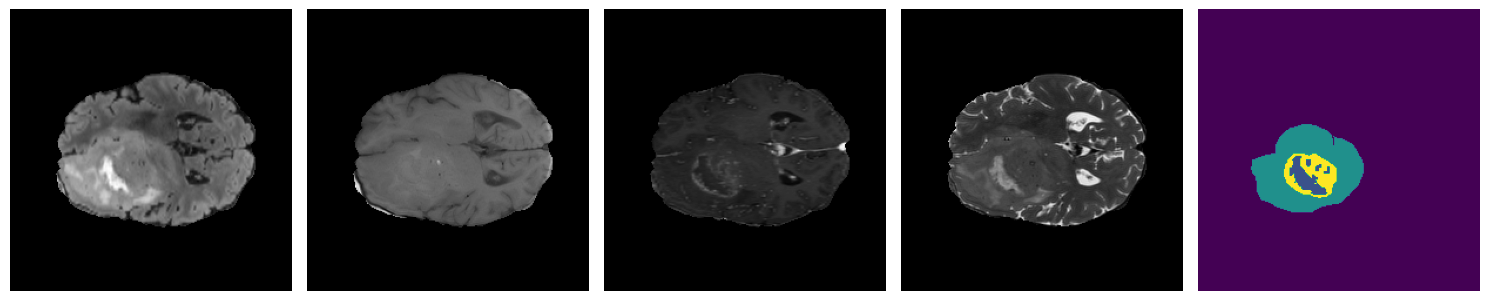

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Cargar el archivo NIfTI desde el directorio
def load_nifty(directory, example_id, suffix):
    return nib.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))

# Cargar todos los canales (flair, t1, t1ce, t2)
def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]

# Obtener datos en un formato específico
def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)

# Preparar los archivos NIfTI y guardarlos en los directorios correspondientes
def prepare_nifty(d, img_path, lbl_path):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nib.nifti1.Nifti1Image(vol, affine, header=header)
    nib.save(vol, os.path.join(img_path, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nib.nifti1.Nifti1Image(vol, affine, header=header)
        nib.save(seg, os.path.join(lbl_path, example_id + "_seg.nii.gz"))

# Paralelizar el procesamiento de datos
def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(*arg) for arg in args)

# Función principal para preparar el conjunto de datos
def prepare_dataset(data):
    img_path = os.path.join(data, "images")
    lbl_path = os.path.join(data, "labels")
    print(f"Preparing BraTS21 dataset from: {data}")
    start = time.time()
    dirs = sorted(glob(os.path.join(data, "BraTS*")))
    run_parallel(prepare_nifty, [(d, img_path, lbl_path) for d in dirs])
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

# Ruta del directorio de entrenamiento
prepare_dataset("/content/drive/My Drive/BraTS2021_Training_Data")
print("Finished!")

Preparing BraTS21 dataset from: /content/drive/My Drive/BraTS2021_Training_Data
Preparing time: 351.83
Finished!


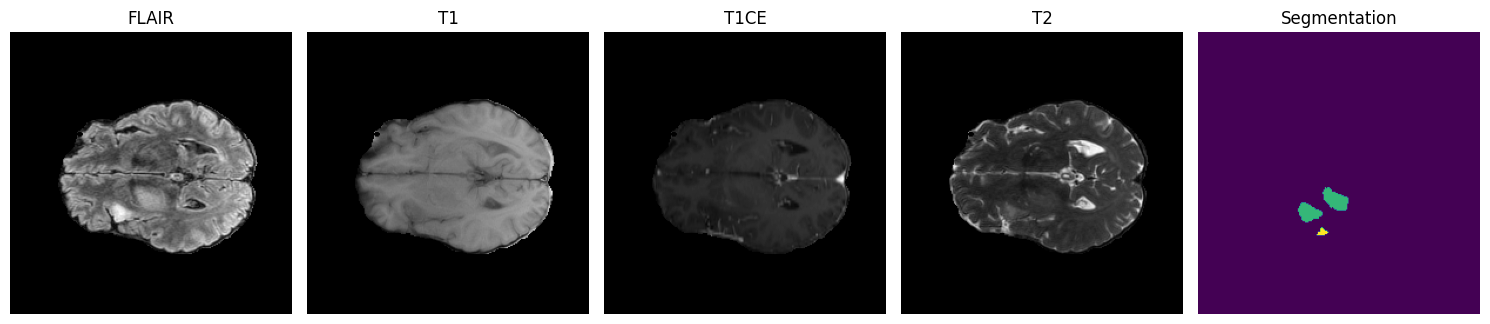

In [ ]:

# Directorio base donde se encuentran las imágenes y etiquetas
base_dir = "/content/drive/My Drive/BraTS2021_Training_Data"

# Identificador del ejemplo
example_id = "BraTS2021_00028"

# Cargar las imágenes y etiquetas para el ejemplo dado
img_path = os.path.join(base_dir, "images", example_id + ".nii.gz")
lbl_path = os.path.join(base_dir, "labels", example_id + "_seg.nii.gz")

# Cargar el archivo NIfTI
img = nib.load(img_path).get_fdata().astype(np.float32)
lbl = nib.load(lbl_path).get_fdata().astype(np.uint8)

# Seleccionar una slice para visualizar (en este caso la 75)
slice_num = 70

# Configurar el gráfico
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

# Graficar cada modalidad
modalities = ["FLAIR", "T1", "T1CE", "T2"]
for i in range(4):
    ax[i].imshow(img[:, :, slice_num, i], cmap='gray')
    ax[i].set_title(modalities[i])
    ax[i].axis('off')

# Graficar la etiqueta (label)
ax[-1].imshow(lbl[:, :, slice_num], vmin=0, vmax=3)
ax[-1].set_title("Segmentation")
ax[-1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def normalize(volume):
    """Normalizar el volumen para que los valores estén entre 0 y 1."""
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    return volume

def crop_center(volume, mask):
    """Recortar el volumen y la máscara centrados en la región no nula."""
    non_zero_coords = np.where(mask > 0)
    min_z, max_z = np.min(non_zero_coords[2]), np.max(non_zero_coords[2])
    min_y, max_y = np.min(non_zero_coords[1]), np.max(non_zero_coords[1])
    min_x, max_x = np.min(non_zero_coords[0]), np.max(non_zero_coords[0])

    cropped_volume = volume[min_x:max_x, min_y:max_y, min_z:max_z]
    cropped_mask = mask[min_x:max_x, min_y:max_y, min_z:max_z]
    return cropped_volume, cropped_mask

def preprocess_and_save(data_dir, img_save_dir, lbl_save_dir):
    """Preprocesar los volúmenes y guardarlos como matrices NumPy en carpetas separadas."""
    os.makedirs(img_save_dir, exist_ok=True)
    os.makedirs(lbl_save_dir, exist_ok=True)

    img_files = sorted(glob(os.path.join(data_dir, "images", "*.nii.gz")))
    lbl_files = sorted(glob(os.path.join(data_dir, "labels", "*.nii.gz")))

    for img_file, lbl_file in zip(img_files, lbl_files):
        # Cargar imágenes y etiquetas
        img = nib.load(img_file).get_fdata().astype(np.float32)
        lbl = nib.load(lbl_file).get_fdata().astype(np.uint8)

        # Recortar y normalizar las imágenes y etiquetas
        img_cropped, lbl_cropped = crop_center(img, lbl)
        img_normalized = normalize(img_cropped)

        # Guardar las imágenes preprocesadas
        img_filename = os.path.basename(img_file).replace('.nii.gz', '_preprocessed.npy')
        np.save(os.path.join(img_save_dir, img_filename), img_normalized)

        # Guardar las etiquetas preprocesadas
        lbl_filename = os.path.basename(lbl_file).replace('.nii.gz', '_preprocessed.npy')
        np.save(os.path.join(lbl_save_dir, lbl_filename), lbl_cropped)

# Directorios de los datos originales y para guardar los preprocesados
data_dir = "/content/drive/My Drive/BraTS2021_Training_Data"
img_save_dir = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/images"
lbl_save_dir = "/content/drive/My Drive//BraTS2021_Preprocessed_Data/labels"

# Preprocesar y guardar los volúmenes
preprocess_and_save(data_dir, img_save_dir, lbl_save_dir)
print("Preprocesamiento y guardado completado.")

Preprocesamiento y guardado completado.


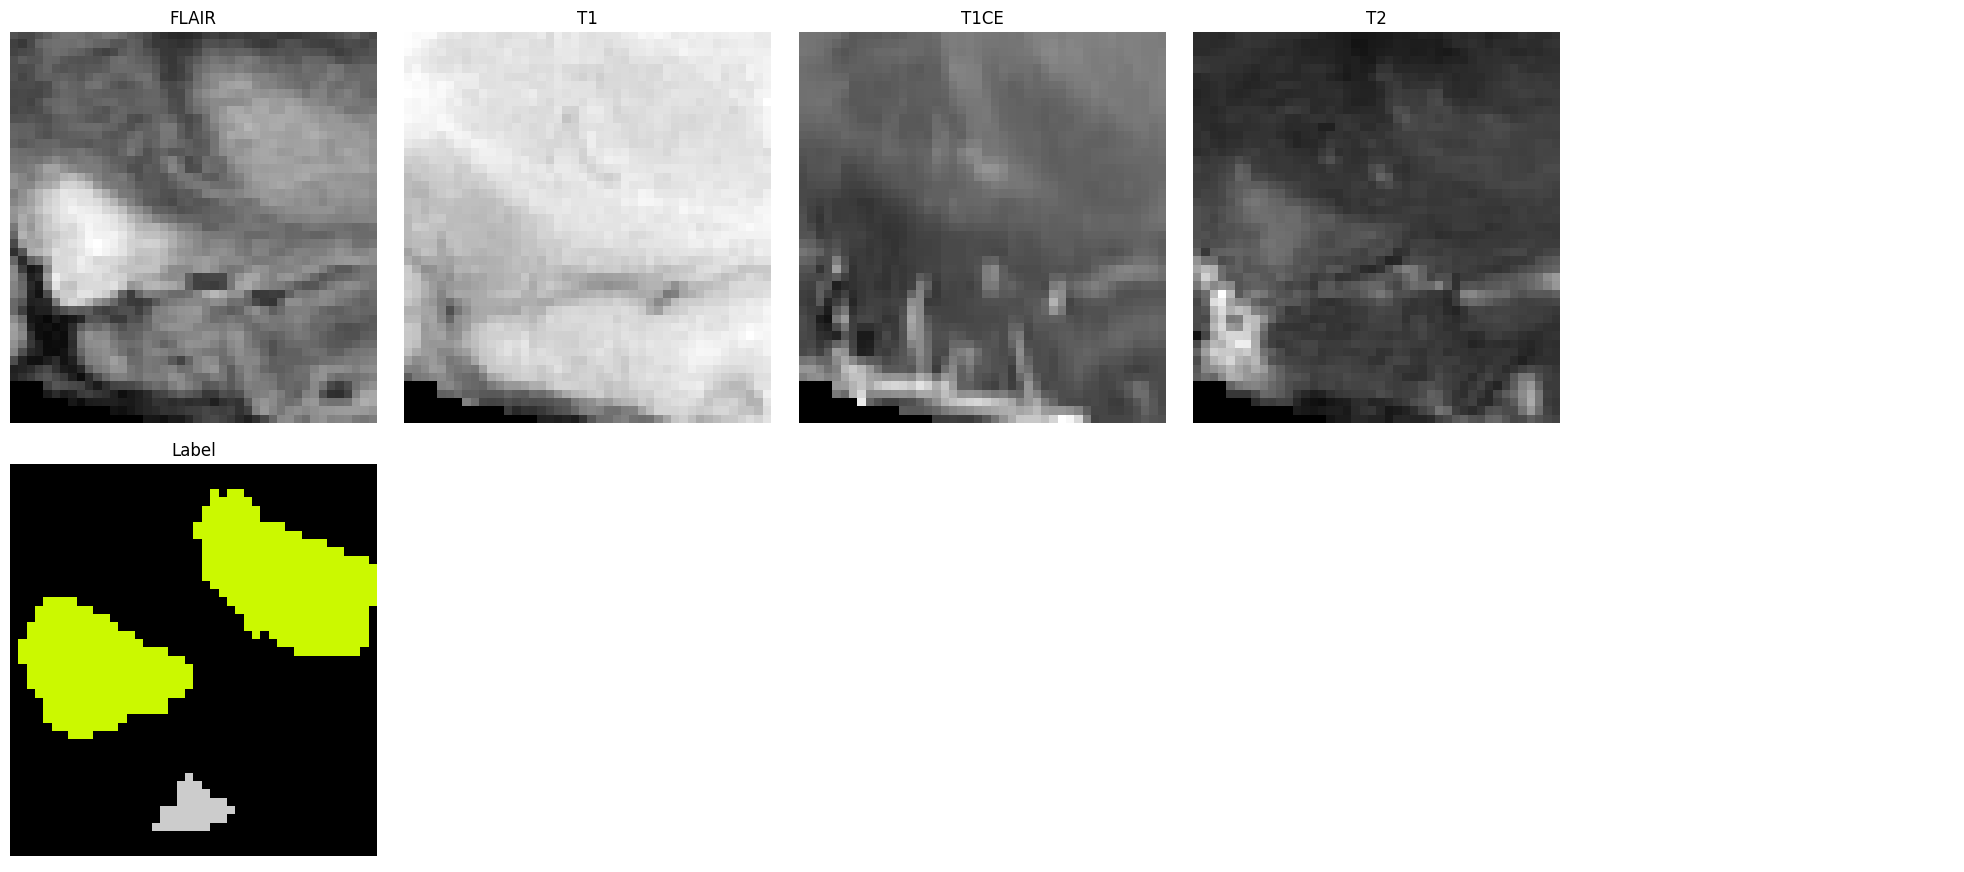

In [ ]:
# Ruta de los directorios de los archivos preprocesados
img_path = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/images"
lbl_path = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/labels"

# Cargar los datos preprocesados
img_file = os.path.join(img_path, "BraTS2021_00028_preprocessed.npy")
lbl_file = os.path.join(lbl_path, "BraTS2021_00028_seg_preprocessed.npy")

img = np.load(img_file)
lbl = np.load(lbl_file)

# Seleccionar un corte en el eje z
z_slice = 25  # Seleccionar el corte central

# Graficar las imágenes y etiquetas
fig, ax = plt.subplots(2, 5, figsize=(20, 9))

# Títulos para las imágenes
titles = ['FLAIR', 'T1', 'T1CE', 'T2', 'Label']

# Graficar las imágenes de diferentes modalidades
for i in range(4):
    ax[0, i].imshow(img[:, :, z_slice, i], cmap='gray')
    ax[0, i].set_title(titles[i])
    ax[0, i].axis('off')

# Graficar la etiqueta
ax[1, 0].imshow(lbl[:, :, z_slice], cmap='nipy_spectral')
ax[1, 0].set_title('Label')
ax[1, 0].axis('off')

# Eliminar los ejes no utilizados
for i in range(1, 5):
    ax[0, i].axis('off')
for i in range(1, 5):
    ax[1, i].axis('off')

# Ajustar el espaciado
plt.tight_layout(pad=2.0)
plt.show()